In [51]:
# imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_classif

# Reading Data

In [52]:
data = torch.load('./Data/Features/vit_b_16_features.pt')
print('Train Data (X, y): ', data['train'][0].shape, data['train'][1].shape)
print('Val Data (X, y): ', data['val'][0].shape, data['val'][1].shape)
print('Test Data (X, y): ', data['test'][0].shape, data['test'][1].shape)

Train Data (X, y):  torch.Size([55000, 768]) torch.Size([55000])
Val Data (X, y):  torch.Size([5000, 768]) torch.Size([5000])
Test Data (X, y):  torch.Size([10000, 768]) torch.Size([10000])


# Data Transformation

## PCA

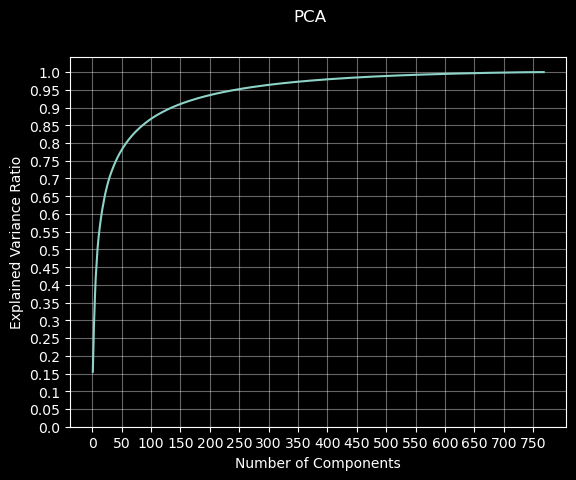

In [53]:
pca = PCA()
pca.fit(data['train'][0])
explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance_ratios)+1), explained_variance_ratios)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.suptitle('PCA')
plt.yticks(np.array(range(0, 105, 5))/100, np.array(range(0, 105, 5))/100)
plt.xticks(range(0, len(explained_variance_ratios)+1, 50), range(0, len(explained_variance_ratios)+1, 50))
plt.grid(True, alpha=0.4)
plt.show()

Based on this plot we can see that with 250 components we are able to explain about 95% of our variance.  
So, we will transform our data using n_components = 250

In [54]:
pca = PCA(n_components=250)
data['train'][0] = pca.fit_transform(data['train'][0])
data['val'][0] = pca.transform(data['val'][0])
data['test'][0] = pca.transform(data['test'][0])

## ANOVA Test

In [55]:
top_features = SelectPercentile(f_classif, percentile=0.9).fit_transform(*data['train'])

# EDA

# Dimensionality Reduction

# Models